In [141]:
import pandas as pd
import numpy as np
import re
import joblib
import pickle
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import random
import seaborn as sns

#load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')
df

,Sentiment,tweet_tokens_stemmed
0,positive,"['undang', 'shanijkt', 'hitamputih', 'pemenang..."
1,positive,"['selamat', 'berbuka', 'puasa', 'semoga', 'ama..."
2,positive,"['trans', 'hitam', 'putih', 'penghargaan', 'no..."
3,positive,"['selamat', 'hitamputih']"
4,positive,"['asiknya', 'nonton', 'hitam', 'putih', 'trans']"
...,...,...
395,negative,"['banget', 'kesel', 'debat', 'pake', 'emosi', ..."
396,negative,"['miskin', 'miskin', 'sekolah', 'pungutan', 'l..."
397,negative,"['emosi', 'cepat', 'tua', 'nonton', 'emosi', '..."
398,negative,"['penampilan', 'kyk', 'preman', 'taunya', 'bki..."


In [142]:
#konversi sentimen positif =1 negatif= 0
def convert_label_sentimen(label_sentimen):
    if label_sentimen == "positive":
        return 1
    else:
        return 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis= 1,inplace=True)
df


,tweet_tokens_stemmed,label_sentimen
0,"['undang', 'shanijkt', 'hitamputih', 'pemenang...",1
1,"['selamat', 'berbuka', 'puasa', 'semoga', 'ama...",1
2,"['trans', 'hitam', 'putih', 'penghargaan', 'no...",1
3,"['selamat', 'hitamputih']",1
4,"['asiknya', 'nonton', 'hitam', 'putih', 'trans']",1
...,...,...
395,"['banget', 'kesel', 'debat', 'pake', 'emosi', ...",0
396,"['miskin', 'miskin', 'sekolah', 'pungutan', 'l...",0
397,"['emosi', 'cepat', 'tua', 'nonton', 'emosi', '...",0
398,"['penampilan', 'kyk', 'preman', 'taunya', 'bki...",0


In [147]:
X= df['tweet_tokens_stemmed'] 
y= df['label_sentimen']
#k-fold cross validation(spliting data)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
for train_idx, val_idx in kfold.split(X, y):
    X_train, X_test = X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((360,), (40,), (360,), (40,))

In [148]:
  # Vektorisasi text menggunakan TF-IDF
tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
X_train = tfidf_model.transform(X_train)
X_test = tfidf_model.transform(X_test)

print(X_train,X_test)

  (0, 1114)	0.47321142314648934
  (0, 1003)	0.3198235856308025
  (0, 974)	0.3198235856308025
  (0, 865)	0.3198235856308025
  (0, 803)	0.3198235856308025
  (0, 697)	0.3198235856308025
  (0, 528)	0.3198235856308025
  (0, 411)	0.3198235856308025
  (0, 356)	0.24507359613689872
  (1, 953)	0.24864114359860165
  (1, 946)	0.3046825670418109
  (1, 871)	0.38148153826807
  (1, 361)	0.38148153826807
  (1, 264)	0.38148153826807
  (1, 114)	0.38148153826807
  (1, 27)	0.38148153826807
  (1, 26)	0.34308205265494046
  (2, 1090)	0.33363281485538665
  (2, 878)	0.29705136250828995
  (2, 821)	0.5980428152694774
  (2, 748)	0.5980428152694774
  (2, 355)	0.2917862489781778
  (3, 946)	0.7215938386007008
  (3, 356)	0.6923166414968701
  (4, 1090)	0.3884684836429908
  :	:
  (355, 482)	0.43648213476012365
  (355, 324)	0.43648213476012365
  (355, 287)	0.4593134857782089
  (355, 212)	0.39206927169665445
  (355, 71)	0.31711383797505793
  (356, 944)	0.37888233696313756
  (356, 876)	0.4212887722012922
  (356, 695)	0.708

In [151]:
def evaluate_features(X, y, indices):
    X_subset = X[:, indices]
    mnb = MultinomialNB()
    mnb.fit(X_subset, y)
    predict = mnb.predict(X_subset)
    return accuracy_score(y, predict)

def pso_feature_selection(X, y, n_particles, n_iterations, learning_rate=0.5):
    n_features = X.shape[1]
    particles_position = np.random.choice([0, 1], size=(n_particles, n_features))
    global_best_position = None
    global_best_score = float('-inf')

    for _ in range(n_iterations):
        for particle_position in particles_position:
            selected_indices = np.where(particle_position == 1)[0]
            score = evaluate_features(X, y, selected_indices)

            if score > global_best_score:
                global_best_score = score
                global_best_position = selected_indices

        # Update particle positions
        for particle_position in particles_position:
            for i in range(len(particle_position)):
                if np.random.rand() < 0.5:
                    particle_position[i] = 1 if np.random.rand() < 0.5 else 0
                else:
                    velocity = 1 / (1 + np.exp(-particle_position[i]))
                    particle_position[i] = 1 if np.random.rand() < velocity else 0

    return global_best_position

In [175]:
# Pemilihan fitur menggunakan PSO
n_particles = 20
n_iterations = 50
selected_indices = pso_feature_selection(X_train.toarray(), y_train, n_particles, n_iterations)
selected_indices

array([   0,    1,    2,    3,    6,    7,    9,   11,   13,   15,   16,
         17,   18,   20,   21,   23,   24,   27,   28,   31,   33,   34,
         35,   36,   37,   42,   45,   47,   48,   49,   50,   53,   54,
         55,   57,   58,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   72,   73,   74,   75,   76,   77,   78,   80,
         81,   88,   89,   90,   93,   94,   95,   96,   99,  100,  101,
        104,  105,  106,  107,  110,  111,  115,  116,  117,  120,  121,
        122,  125,  128,  129,  131,  134,  135,  137,  138,  139,  140,
        141,  142,  146,  148,  150,  153,  157,  159,  161,  164,  166,
        167,  168,  170,  175,  176,  177,  178,  179,  180,  182,  183,
        185,  186,  187,  188,  189,  190,  193,  194,  198,  199,  201,
        202,  203,  205,  206,  208,  209,  212,  213,  215,  219,  220,
        221,  223,  226,  228,  231,  233,  236,  238,  239,  240,  242,
        243,  246,  247,  248,  250,  251,  253,  2

In [176]:
# Memilih fitur terbaik untuk data training dan testing
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
print("Isi X_train_selected:")
print(X_train_selected)
print("\nIsi X_test_selected:")
print(X_test_selected)

Isi X_train_selected:
  (0, 506)	0.3198235856308025
  (0, 307)	0.3198235856308025
  (0, 202)	0.24507359613689872
  (1, 557)	0.24864114359860165
  (1, 509)	0.38148153826807
  (1, 205)	0.38148153826807
  (1, 17)	0.38148153826807
  (2, 642)	0.33363281485538665
  (3, 202)	0.6923166414968701
  (4, 642)	0.3884684836429908
  (4, 444)	0.35937749189128315
  (4, 32)	0.6963367368465202
  (5, 4)	0.334547875354782
  (6, 218)	0.6456316159082433
  (7, 4)	0.41094486671207364
  (8, 270)	1.0
  (9, 642)	0.31955055430204565
  (9, 313)	0.3812664085618694
  (9, 179)	0.5151427208268193
  (10, 381)	0.5632057792461003
  (11, 557)	0.4361079294835002
  (11, 303)	0.6017540036247514
  (12, 642)	0.45514451395490985
  (13, 669)	0.3013798619405049
  (13, 589)	0.3013798619405049
  :	:
  (347, 87)	0.26910502139322423
  (347, 81)	0.26910502139322423
  (348, 600)	0.68278460765254
  (348, 461)	0.7306197229426309
  (351, 14)	0.456016950487247
  (352, 564)	0.35226258287079115
  (352, 368)	0.35226258287079115
  (352, 349)	0.

In [177]:
#klasifikasi
mnb_selected = MultinomialNB()
mnb_selected.fit(X_train_selected, y_train)
predict_selected = mnb_selected.predict(X_test_selected)
predict_selected

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

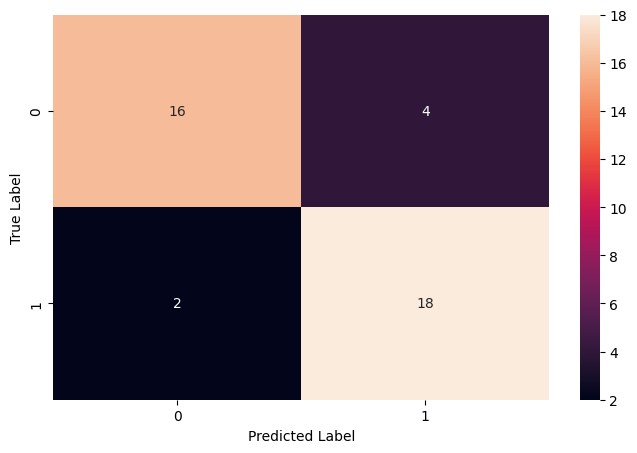

In [178]:
#confusion matrix model
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_selected), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [179]:
# Skor akurasi model
print('accuracy after PSO feature selection : ')
print(accuracy_score(y_test, predict_selected)*100)

accuracy after PSO feature selection : 
85.0
